# Lab 9 - K-means and Spectral Clustering

This lab will demonstrate the K-means and spectral clustering methods on some simple data sets. 

## Clustering 2D data

We will being by showinghow both these algorithms work on data with only two dimensions. First, let's generate some data using the scikit-learn `make_moons` function. This data is spread out so a method like K-means clustering will struggle as it is assigning data points to a cluster based on the distance of the data point to a centroid (mean of a cluster). 

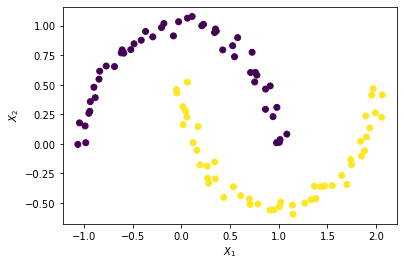

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Create a simple data set with 2 labels
Nsamples = 100
data, true_labels = datasets.make_moons(n_samples=Nsamples, noise=0.05)

# Plot the x1, x2 data and colour based on the class label
plt.scatter( data[:,0], data[:,1], c=true_labels)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

Now we have some simple data, we can try to cluster the data using scikit-learns K-means algorithm.

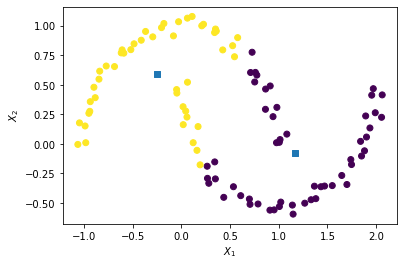

In [2]:
from sklearn.cluster import k_means

K = 2

# The sklearn k_means function returns the positions of the centroids,
# a list of which cluster each datapoint is assigned to and the inertia
# which is another name for the within cluster scatter
km_centroids, km_clusters, inertia = k_means(data, n_clusters=K)

plt.scatter( data[:,0], data[:,1], c=km_clusters)
plt.scatter( km_centroids[:,0], km_centroids[:,1], s = 30, marker='s')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()


In this example, the K-meanscan't separate out the 'moon' shapes as they are a complex cluster.

So let's try with the spectral clustering algorithm instead. In this case, we will pre-compute the simaliry matrix (also called the affinity matrix) using the Gaussian basis (radial basis function) discussed in the lecture. To calculate the squared distance of each data point with another we can use the `cdist` function that is part of the scipy library. The 'sqeuclidean' tells the function that we want the squared Euclidean distance and so returns a matrix where each element is $(\mathbf{x}_i - \mathbf{x}_j)^2$. 

In [3]:
from scipy.spatial.distance import cdist

sigma = 0.2
W = np.exp(-0.5*cdist(data, data, 'sqeuclidean')/sigma**2)

Before we apply spectral clustering on this graph, we can try to visualise this by plotting all these connection between the data points:

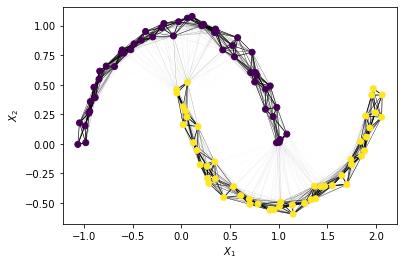

In [4]:
def plot_graph(data, labels, W):
    for i,xi in enumerate(data):
        for j,xj in enumerate(data):
            if (j > i) and (W[i,j] > 0.001):
                plt.plot([xi[0], xj[0]], [xi[1], xj[1]], '-k', linewidth = W[i,j], zorder=1)
    plt.scatter(x=data[:,0], y=data[:,1], c=labels, zorder=2 )
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.show()
    
plot_graph(data, true_labels, W)

When we plot the connections in this way we can see that data points that make up each cluster have many connections but there are only a few connections between each moon. 

Now we have the similarity or affinity matrix we can use the `spectral_clustering` function in skleanr.cluster to apply the method:

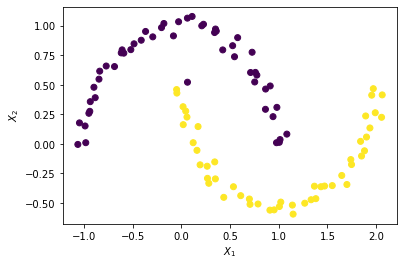

In [5]:
from sklearn.cluster import spectral_clustering

# Apply spectral clustering on the precalculated similarity matrix W
sc_clusters = spectral_clustering(W, n_clusters=K)

# Plot the 2 clusters
plt.scatter( data[:,0], data[:,1], c=sc_clusters)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

We can see that the spectral clustering has managed to separate out these complex clusters. Although there are a few points that get grouped wrongly.

**Question 1**

Now that we have our cluster labels (i.e graph partition) we can test the results by calculating the normalised cut as we did in class. Write a function to calculate the normalised cut based on the cluster list returned. Remember that the normalised cut is defined as 
$$ \mathrm{Ncut}(A,B) = \mathrm{cut}(A,B) \left( \frac{1}{\mathrm{vol}(A)} + \frac{1}{\mathrm{vol}(B)} \right) $$
where
$$ \mathrm{cut}(A,B) = \sum_{i \in A} \sum_{j \in B} W_{ij}, $$
$$ \mathrm{vol}(A) = \sum_{i \in A} d_i,$$
$$ d_i = \sum_j W_{ij} $$

In [6]:
# we can get a list of all the datapoints in each cluster by using np.where
A = np.where(sc_clusters == 0)

# Answer here

**Question 2**

Vary the sigma parameter when calculating the W matrix, plot the connections as above and then repeat the spectral clustering on the new W matrix. How have the results changed?

In [7]:
# Answer here

## Clustering images

Now that we have seen the clustering algorithms working on a simple dataset, we will apply them to a dataset with more dimensions. We will use the scikit-learn digits dataset, which has images of handwritten digits 0-9 on an 8x8 pixel grid. In total this is 64 dimensions 

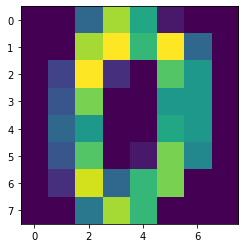

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()

plt.imshow(digits.images[0])
plt.show()

# scale the data into the range [0,1]
X = digits.data/16.0
true_labels = digits.target
N = len(X)

To observe what is going on we can use PCA to transform this 64 dimensional data into 2 dimensions that we can plot. We will still perform the clustering in the full data space but this helps visualisation.

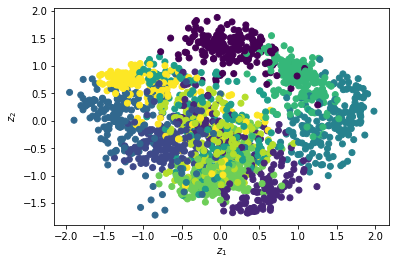

In [9]:
from sklearn.decomposition import PCA

# Set up PCA with 2 components then transform our data into this represenation.
pca = PCA(n_components=2)
z = pca.fit_transform(X)

plt.scatter( z[:,0], z[:,1], c=true_labels)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

Hopefully you can now see that even with only the first 2 principal components the data is still relatively grouped together. Lets start by applying K-means and try to find 10 clusters (the number of clusters does not have to match the number of classes).

In [10]:
K = 10
km_centroids, km_clusters, inertia = k_means(X, n_clusters=K)

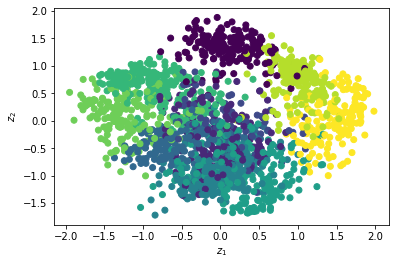

In [11]:
plt.scatter(x=z[:,0], y=z[:,1], c=km_clusters, zorder=2 )
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

Visually we can see that the clusters that we have found have some similarity to the original layout of the classes. THe colours will have changed as we are plotting clusters here and they won't necessarily match up. To test how good the clustering is we can measure the performance against our class labels. A use measurement is known as the cluster purity. This is calculated as the fraction of data points with the most common label in that cluster against the cluster size. So if a cluster has 10 data points of label 1, 3 of label 2, 5 of label 3  and 2 of label 9 then the most common label is 1 and the purity is 10/20 = 0.5. 

**Question 3**

Use the cluster list return by the K-means algorithm to calculate the most common true label and purity of each cluster. When you have the purity of each cluster $p_k$ calculate an average purity using 
$$ \langle p \rangle  = \sum_k \frac{n_k }{N} p_k $$
 where $n_k$ is the number of datapoints in each cluster and $N$ the total number of data points. Comment on the performance.

You may find the `np.unique` function useful as it has an option to return a count of each unique element in an array. Remember you can use `np.where` to find which data points are in each cluster.

In [12]:
# answer here

**Question 4**

Now apply spectral clustering to the digits dataset as we applied it for the 2D dataset. For this you will need to use the Gaussian Kernel to calculate the similarity matrix W, when you do this use `sigma=2.0`. When you have found the clusters, make a scatter plot of the PCA data points coloured by the cluster (as above) and calculate the purity of each cluster and the average purity. Compare the results to the K-means solution, which has done better? 

In [13]:
# Answer here

**Question 5**

Calculate the average purity for 5 different values of sigma. Plot these on a graph. Is there an optimum value for sigma?



In [14]:
# Answer here

**Question 6**

Apply the K-means algorithm but vary the number of clusters between 5 and 25 and store the intertia (within cluster scatter) and average purity for each. Plot these two quantites against the number of clusters. Is there a clear choice for the best number of clusters.

In [15]:
# Answer here

## Further reading

Have a look at the sci-kit learn example on using [spectral clustering for image segmentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html#sphx-glr-auto-examples-cluster-plot-coin-segmentation-py).

If you want to see more detail about spectral clustering is used for finding many clusters, there is a good description in this tutorial by [Ulrike von Luxburg](https://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf).